In [ ]:
from dataclasses import dataclass
from fastai.vision.all import *
from fastai.vision.gan import *
from functools import partial
import numpy as np 
import pandas as pd
from pathlib import Path
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable

In [2]:
run_as_standalone_nb = False

In [3]:
if run_as_standalone_nb:
    root_lib_path = Path('face2anime').resolve()
    if not root_lib_path.exists():
        !git clone https://github.com/davidleonfdez/face2anime.git
    if str(root_lib_path) not in sys.path:
        sys.path.insert(0, str(root_lib_path))
else:
    import local_lib_import

In [4]:
from face2anime.gen_utils import is_iterable
from face2anime.layers import ConcatPoolHalfDownsamplingOp2d, ConvHalfDownsamplingOp2d, TransformsLayer
from face2anime.losses import ContentLossCallback, CritPredsTracker, LossWrapper, R1GANGPCallback
from face2anime.misc import FeaturesCalculator
from face2anime.networks import Img2ImgGenerator, patch_res_critic, res_critic
from face2anime.train_utils import (add_ema_to_gan_learner, custom_load_model,
                                    custom_save_model)
from face2anime.transforms import AdaptiveAugmentsCallback, ADATransforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 64
save_cycle_len = 5

# Data

## Target ds

animecharacterfaces, by Kaggle user *aadilmalik94*

In [ ]:
anime_ds_path = Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data').resolve()

## Input ds

In [ ]:
celeba_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')
#input_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
input_fns = celeba_path.ls()
input_fns

The ds path passed to `dblock.dataloaders()` or `ImageDataLoaders.from_dblock()` will be forwarded
to `get_items`, which will return a list of items, usually a list of image paths if `get_items=get_image_files`.

So, for each item, we are expected to receive a filename `fn` and be able to
derive x and y from it, with `get_x(fn)` and `get_y(fn)`.

For unpaired image to image translation, we can:
* Use the target images ds path as the DataBlock `source`. Then, `get_y` can just return the path received.
* Load independently the filenames of the input images ds; let's call it `input_fns`. Then, `get_x` would need to return a random item from `input_fns`. `get_x` is called every time a data item is used; so, by using random, we can be sure every x is not tied to a fixed y; i.e., they won't be together in the same (x, y) batch every epoch for loss calculation.


---

In [ ]:
def get_random_input(fn):
    return input_fns[random.randint(0, len(input_fns)-1)]


normalize_tf = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))


def get_dblock(extra_batch_tfms=None):
    if extra_batch_tfms is None: extra_batch_tfms = []    
    return DataBlock(blocks=(ImageBlock, ImageBlock),
                     get_x=get_random_input,
                     get_items=get_image_files,
                     #get_items=lambda path: target_fns,
                     splitter=IndexSplitter([]),
                     item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                     batch_tfms=[normalize_tf] + extra_batch_tfms)


dblock = get_dblock()
main_path = anime_ds_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

In [ ]:
dls.show_batch()

# Loss function utils

In [ ]:
vgg_content_layers_idx = [22]
ftrs_calc = FeaturesCalculator([], vgg_content_layers_idx, device=device,
                               input_norm_tf=normalize_tf)

## Reconstruction loss

In [ ]:
@dataclass
class ReconstructionLossWeights:
    real_to_real:float=1.
    latent_a_to_latent:float=1.
    latent_b_to_latent:float=1.

class ReconstructionLossCallback(Callback):
    def __init__(self, enc_dec_generator:nn.Module, weights:ReconstructionLossWeights,
                 n_ch=3, eval_real_b_to_real=True, eval_latent_a_to_latent=True, 
                 eval_latent_b_to_latent=True, loss_func:Callable=None):
        self.generator = enc_dec_generator
        self.weights = weights
        self.eval_real_b_to_real = eval_real_b_to_real
        self.eval_latent_a_to_latent = eval_latent_a_to_latent
        self.eval_latent_b_to_latent = eval_latent_b_to_latent
        self.latent_layer_idx = 0
        if eval_latent_a_to_latent or eval_latent_b_to_latent:
            self.latent_layer_idx = self._get_latent_layer_idx(n_ch)
        self.loss_func = F.l1_loss if loss_func is None else loss_func
        
    def _get_latent_layer_idx(self, n_ch:int):
        with hook_outputs(self.generator) as all_hooks:
            last_spatial_size = 64
            self.generator(torch.rand(2, n_ch, last_spatial_size, last_spatial_size))
            latent_code_layer_idx = 0
            for i, h in enumerate(all_hooks):
                if h.stored.shape[-1] > last_spatial_size:
                    break
                last_spatial_size = h.stored.shape[-1]
                latent_code_layer_idx = i
            return latent_code_layer_idx
        
    def after_loss(self):
        if not self.gan_trainer.gen_mode: return
        eval_any_latent = self.eval_latent_a_to_latent or self.eval_latent_b_to_latent
        mid_hook = hook_output(self.generator[self.latent_layer_idx]) if eval_any_latent else None
        #encoder = nn.Sequential(*self.generator[:self.latent_layer_idx+1]) if eval_any_latent else None
        
        if self.eval_real_b_to_real:
            fake = self.generator(self.y)
            real_to_real_loss = self.loss_func(fake, self.y) * self.weights.real_to_real
            self.learn.loss_grad += real_to_real_loss
            # Store result inside learn.loss_func to make it visible to metrics display
            self.learn.loss_func.real_rec_loss = real_to_real_loss
            
        # Watchout: order matters! This `if` needs to be placed before the next one
        # (`if self.eval_latent_a_to_latent`) because mid_hook.stored is reused 
        # when (self.eval_real_b_to_real == True)       
        if self.eval_latent_b_to_latent:
            if mid_hook.stored is None:
                fake = self.generator(self.y)
            latent_b = mid_hook.stored
            # TODO: it would be more efficient to execute `encoder(fake)` only, but not sure 
            # if it could be possible w/o losing computation graph
            self.generator(fake)
            latent_b_rec = mid_hook.stored
            latent_b_rec_loss = self.loss_func(latent_b, latent_b_rec) * self.weights.latent_b_to_latent
            self.learn.loss_grad += latent_b_rec_loss
            # Store result inside learn.loss_func to make it visible to metrics display
            self.learn.loss_func.latent_b_rec_loss = latent_b_rec_loss
            
        if self.eval_latent_a_to_latent:
            fake = self.generator(self.x)
            latent_a = mid_hook.stored
            self.generator(fake)
            latent_a_rec = mid_hook.stored
            latent_a_rec_loss = self.loss_func(latent_a, latent_a_rec) * self.weights.latent_a_to_latent
            self.learn.loss_grad += latent_a_rec_loss
            # Store result inside learn.loss_func to make it visible to metrics display
            self.learn.loss_func.latent_a_rec_loss = latent_a_rec_loss
            
        if eval_any_latent:
            mid_hook.remove()


class DummyGen(nn.Module):
    """Generator composed by convs whose weights are full of ones with no bias."""
    def __init__(self, n_ftrs, k_szs, strides, paddings, transpose):
        super().__init__()
        convs = []
        for i, (nf, ks, stride, pad, tr) in enumerate(zip(n_ftrs[:-1], k_szs, strides, paddings, transpose)):
            conv_func = nn.ConvTranspose2d if tr else nn.Conv2d
            conv = conv_func(nf, n_ftrs[i+1], kernel_size=ks, stride=stride, padding=pad, bias=False)
            convs.append(conv)
            nn.init.constant_(conv.weight, 1)
        self.convs = nn.Sequential(*convs)

    def forward(self, x):
        return self.convs(x)
    
    def __iter__(self): return iter(self.convs)
    def __getitem__(self,i): return self.convs[i]

class DummyCritic(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return torch.zeros(x.size()[0], 1).requires_grad_(True)
    

def test_rec_loss():        
    n_ch = 3
    mid_ftrs = 6
    resample_ks = 4
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                       # float tensor full of 1.'s
                       get_x=lambda fn: np.full((4, 4, n_ch), 255, dtype=np.uint8),
                       splitter = IndexSplitter([]),
                       # float tensor full of 0.2's
                       get_y=lambda fn: np.full((4, 4, n_ch), 51, dtype=np.uint8))
    dls = dblock.dataloaders(['', ''], bs=2)
    gen = DummyGen([n_ch, mid_ftrs, n_ch], [resample_ks, resample_ks], 
                   [2, 2], [0, 0], [False, True])
    crit = DummyCritic()    
    weights = ReconstructionLossWeights(1, 2, 3)
    rec_loss_cb = ReconstructionLossCallback(gen, weights)
    learn = GANLearner.wgan(dls, gen, crit, cbs=[rec_loss_cb], gen_first=True) #metrics = [...]
    learn.fit(1)
    
    deeper_gen = DummyGen([n_ch, mid_ftrs, mid_ftrs, mid_ftrs, n_ch], [resample_ks, 3, 3, resample_ks], 
                          [2, 1, 1, 2], [0, 0, 0, 0], [False, False, False, True])
    rec_loss_cb_deeper_gen = ReconstructionLossCallback(deeper_gen, weights)
    
    
    # Expected results are almost hardcoded in order to avoid repeating potential coding errors
    # from test code, although we are unnecessarily testing DummyGen at the same time.
    # If input=torch.full((bs, n_ch, 4, 4), item_val) ...
    #   -After first conv, out=torch.full((bs, 6, 1, 1), item_val*n_ch*(resample_ks**2))
    #   -After second conv, out=torch.full((bs, 3, 4, 4), (item_val*n_ch*(resample_ks**2))*mid_ftrs
    #   -After first conv, second forward, out=torch.full((bs, 6, 1, 1), ((item_val*n_ch*(resample_ks**2))*mid_ftrs)*n_ch*(resample_ks**2))
    real_out_values = 0.2 * mid_ftrs * n_ch * resample_ks**2
    expected_real_rec_loss = weights.real_to_real * abs(real_out_values - 0.2)    
    
    # Latent code obtained passing real target (y) as input
    latent_b_values = 0.2 * n_ch * resample_ks**2
    latent_b_rec_values = 0.2 * mid_ftrs * n_ch**2 * resample_ks**4
    expected_latent_b_rec_loss = weights.latent_b_to_latent * abs(latent_b_rec_values - latent_b_values)
    
    # Latent code obtained passing real input (x) as input
    latent_a_values = n_ch * resample_ks**2
    latent_a_rec_values = mid_ftrs * n_ch**2 * resample_ks**4
    expected_latent_a_rec_loss = weights.latent_a_to_latent * abs(latent_a_rec_values - latent_a_values)

    # A more concise but also error prone form would be:
#     y = torch.full((bs, n_ch, 4, 4), 0.2)
#     real_out = gen(y)
#     expected_real_rec_loss = weights.real_to_real * F.l1_loss(real_out, y)
#     latent_b = gen[0](y)
#     latent_b_rec = gen[0](gen[1](latent_b)) 
#     expected_latent_b_rec_loss = weights.latent_b_to_latent * F.l1_loss(latent_b_rec, latent_b)
#     x = torch.ones(bs, n_ch, 4, 4)
#     latent_a = gen[0](x)
#     latent_a_rec = gen[0](gen[1](latent_a))
#     expected_latent_a_rec_loss = weights.latent_a_to_latent * F.l1_loss(latent_a_rec, latent_a)
    
    expected_loss = expected_real_rec_loss + expected_latent_b_rec_loss + expected_latent_a_rec_loss
        
    assert rec_loss_cb._get_latent_layer_idx(n_ch) == 0
    assert rec_loss_cb_deeper_gen._get_latent_layer_idx(n_ch) == 2
    assert math.isclose(learn.recorder.losses[0], expected_loss, rel_tol=1e-5)

In [ ]:
test_rec_loss()

------------------

# Training

In [ ]:
def predict_n(learner, n_imgs, max_bs=64):
    dummy_path = Path('')
    dl = learner.dls.test_dl([dummy_path]*n_imgs, bs=max_bs)   
    inp, imgs_t, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch((inp,) + tuplify(dec_imgs_t), max_n=n_imgs)
    return dec_batch
    
def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 2, figsize=(6, n_imgs * 3))
    for i, (inp, pred_img) in enumerate(preds_batch):
        inp.show(ax=axs[i][0])
        pred_img.show(ax=axs[i][1])
        
class SaveCheckpointsCallback(Callback):
    "Callback that saves the model at the end of each epoch."
    def __init__(self, fn_prefix, base_path=Path('.'), initial_epoch=1,
                 save_cycle_len=1):
        self.fn_prefix = fn_prefix
        self.base_path = base_path
        self.epoch = initial_epoch
        self.save_cycle_len = save_cycle_len
        
    def after_epoch(self):
        if (self.epoch % self.save_cycle_len) == 0:
            fn = f'{self.fn_prefix}_{self.epoch}ep'
            custom_save_model(self.learn, fn, base_path=self.base_path)
        self.epoch += 1
        
def save_preds(c_preds_tracker, filepath):
    return c_preds_tracker.to_df().to_csv(filepath)
        
def plot_c_preds(c_preds_tracker):
    preds_xs = range(len(c_preds_tracker.real_preds))
    sns.lineplot(x=preds_xs, y=c_preds_tracker.fake_preds.cpu(), label='Fake preds')
    ax=sns.lineplot(x=preds_xs, y=c_preds_tracker.real_preds.cpu(), label='Real preds')
    ax.set_xlabel('Number of batches')
    ax.set_ylabel('Critic preds')

In [ ]:
def set_inn_options(net, **inn_kwargs):
    for k, module in net.named_modules():
        if not isinstance(module, nn.InstanceNorm2d): continue
        editable_module = net
        accesors = k.split('.')
        for accesor in accesors[:-1]:
            editable_module = (editable_module[int(accesor)] if accesor.isnumeric()
                              else getattr(editable_module, accesor))
        new_module = InstanceNorm(module.num_features, **inn_kwargs)
        if accesors[-1].isnumeric():
            editable_module[int(accesors[-1])] = new_module
        else:
            setattr(editable_module, accesors[-1], new_module)

In [ ]:
@dataclass
class ADAConfig:
    p_change_thresh:float=0.6
    filter_tfms_to_array:Callable=None
    pad_mode:PadMode=PadMode.Reflection
    

def create_learner(for_inference=False, ada_conf=None, dblock=dblock, dls=dls, gp_w=1.,
                   latent_sz=100, g_norm=NormType.Instance, mid_mlp_depth=0,
                   n_extra_convs_by_c_res_block=0, g_skips=False, n_crit_iters=1, 
                   metrics=None, use_patch_critic=False):
    use_ada = ada_conf is not None
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    crit_args = [img_size, n_channels, down_op, id_down_op]
    if use_patch_critic: crit_args.insert(2, img_size//8)
    crit_kwargs = dict(n_extra_convs_by_res_block=n_extra_convs_by_c_res_block, 
                       act_cls=leakyReLU02, bn_1st=False, n_features=128, 
                       flatten_full=True)
    crit_builder = patch_res_critic if use_patch_critic else res_critic
    base_critic = crit_builder(*crit_args, **crit_kwargs)
    if not use_ada: critic = base_critic
    
    def _decoder_builder(imsz, nch, latsz, hooks_by_sz=None): 
        return default_decoder(imsz, nch, latsz, norm_type=g_norm, hooks_by_sz=hooks_by_sz)
    generator = Img2ImgGenerator(img_size, n_channels, mid_mlp_depth=mid_mlp_depth, skip_connect=g_skips,
                                 encoder=default_encoder(img_size, n_channels, latent_sz, norm_type=g_norm),
                                 decoder_builder=_decoder_builder)
    
    cbs = []
    c_loss_interceptors = []
    tfms_array = []
    
    if not for_inference:
        # Pass base_critic to avoid grid_sample 2nd order derivative issue with ADA critic
        cbs.append(R1GANGPCallback(weight=gp_w, critic=base_critic))
        #cbs.append(ContentLossCallback(weight=content_loss_w, ftrs_calc=ftrs_calc, device=device))
        #cbs.append(ReconstructionLossCallback(generator, rec_loss_weights, **rec_loss_cb_kwargs))
        if use_ada:
            ada_tfms = ADATransforms(0., (img_size, img_size), pad_mode=ada_conf.pad_mode)
            tfms_array = (ada_conf.filter_tfms_to_array(ada_tfms) if ada_conf.filter_tfms_to_array is not None
                          else ada_tfms.to_array())
            ada_crit_preds_tracker = CritPredsTracker(reduce_batch=False)
            ada_cb = AdaptiveAugmentsCallback(ada_tfms, ada_crit_preds_tracker,
                                              preds_above_0_overfit_threshold=ada_conf.p_change_thresh)
            cbs.append(ada_cb)
            c_loss_interceptors.append(ada_crit_preds_tracker)
        overall_crit_preds_tracker = CritPredsTracker(reduce_batch=True)
        c_loss_interceptors.append(overall_crit_preds_tracker)
       
    if use_ada:
        critic = nn.Sequential(TransformsLayer(setup_aug_tfms(tfms_array)),
                               base_critic)       
    
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=n_crit_iters, n_gen=1),
                       switch_eval=False, metrics=metrics)
    #metrics=LossMetric('content_loss')
    #metrics=LossMetrics(['real_rec_loss', 'latent_a_rec_loss', 'latent_b_rec_loss'])
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, decay=0.999)
    if not for_inference: learn.crit_preds_tracker = overall_crit_preds_tracker
    return learn

## TR 1: NSGAN-R1GP loss, SN+BN critic, IN+SN gen (both encoder and decoder), no mid MLP 

### TR 1a: global critic

In [ ]:
def create_learner_1(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Batch, mid_mlp_depth=2,
                          g_skips=True, n_extra_convs_by_c_res_block=1, n_crit_iters=3)

In [ ]:
learn = create_learner_1()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr1', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
# custom_load_model(learn, 'refined_arch_face2anime_tr1_100ep', base_path='../input/refined-arch-face2anime/', with_ema=True)
# #preds_df = pd.read_csv(io.StringIO(preds_csv_str), index_col=0)
# #learn.crit_preds_tracker.load_from_df(preds_df, device)
# with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
#     displayable_learn.show_results(ds_idx=0)

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr1_100ep.csv'))

### TR 1b: patch critic

In [ ]:
def create_learner_1b(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Batch, mid_mlp_depth=2,
                          g_skips=True, n_extra_convs_by_c_res_block=0, n_crit_iters=3,
                          use_patch_critic=True)

In [ ]:
learn = create_learner_1b()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr1b', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr1b_100ep.csv'))

### TR 1c: patch critic, tfms = {Flip, Warp}

In [ ]:
def create_learner_1c(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), Warp(p=0.5)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)    
    
    return create_learner(*args, **kwargs, for_inference=for_inference, dblock=aug_dblock, 
                          dls=aug_dls, gp_w=10., g_norm=NormType.Batch, mid_mlp_depth=2, 
                          g_skips=True, n_extra_convs_by_c_res_block=0, n_crit_iters=3,
                          use_patch_critic=True)

In [ ]:
learn = create_learner_1c()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr1c', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr1c_100ep.csv'))

### TR 1d: patch critic, tfms = {Flip, Warp, Zoom}

In [ ]:
def create_learner_1d(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), Warp(p=0.5), Zoom(p=0.5, max_zoom=1.1)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)    
    
    return create_learner(*args, **kwargs, for_inference=for_inference, dblock=aug_dblock, 
                          dls=aug_dls, gp_w=10., g_norm=NormType.Batch, mid_mlp_depth=2, 
                          g_skips=True, n_extra_convs_by_c_res_block=0, n_crit_iters=3,
                          use_patch_critic=True)

In [ ]:
learn = create_learner_1d()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr1d', initial_epoch=91,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr1d_100ep.csv'))

## TR2 [TR1 + ADA]: NSGAN-R1GP loss, SN+BN critic, IN+SN gen (both encoder and decoder), no mid MLP, ADA

In [ ]:
def filter_spatial_minus_flip_rot_small(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() 
            if (isinstance(tfm, (AffineCoordTfm)) and not isinstance(tfm, (Rotate, Flip)))
                or tfm == ada_tfms.rotate_90x]

aug_dblock = get_dblock(extra_batch_tfms=[Flip(0.5)])
aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)


def create_learner_2(*args, **kwargs):
    return create_learner(*args, 
                          ada_conf=ADAConfig(filter_tfms_to_array=filter_spatial_minus_flip_rot_small, 
                                             p_change_thresh=0.6), 
                          dblock=aug_dblock,
                          dls=aug_dls,
                          gp_w=10., 
                          g_norm=NormType.Batch, 
                          mid_mlp_depth=2,
                          g_skips=True, 
                          n_extra_convs_by_c_res_block=1, 
                          n_crit_iters=3,
                          **kwargs)

### TR 2a: global critic

In [ ]:
learn = create_learner_2()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr2', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr2_100ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_face2anime_refined_tr2_100ep.txt

### TR 2b: patch critic

In [ ]:
def create_learner_2b(*args, **kwargs):
    return create_learner(*args, 
                          ada_conf=ADAConfig(filter_tfms_to_array=filter_spatial_minus_flip_rot_small, 
                                             p_change_thresh=0.8), 
                          dblock=aug_dblock,
                          dls=aug_dls,
                          gp_w=10., 
                          g_norm=NormType.Batch, 
                          mid_mlp_depth=2,
                          g_skips=True, 
                          n_extra_convs_by_c_res_block=0, 
                          n_crit_iters=3,
                          use_patch_critic=True,
                          **kwargs)

In [ ]:
learn = create_learner_2b()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr2b', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('crit_preds_face2anime_refined_tr2b_100ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_face2anime_refined_tr2b_100ep.txt

### TR 2c: patch critic, regular tfms = {Flip, Warp, Zoom}

In [ ]:
def filter_spatial_minus_flip_rot_small_warp_zoom(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() 
            if (isinstance(tfm, (AffineCoordTfm)) and not isinstance(tfm, (Rotate, Flip, Warp, Zoom)))
                or tfm == ada_tfms.rotate_90x]

def create_learner_2c(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), Warp(p=0.5), Zoom(p=0.5, max_zoom=1.1)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)
    
    return create_learner(*args, 
                          for_inference=for_inference,
                          ada_conf=ADAConfig(filter_tfms_to_array=filter_spatial_minus_flip_rot_small_warp_zoom, 
                                             p_change_thresh=0.8), 
                          dblock=aug_dblock,
                          dls=aug_dls,
                          gp_w=10., 
                          g_norm=NormType.Batch, 
                          mid_mlp_depth=2,
                          g_skips=True, 
                          n_extra_convs_by_c_res_block=1, 
                          n_crit_iters=3,
                          use_patch_critic=True,
                          **kwargs)

In [ ]:
learn = create_learner_2c()
learn.add_cb(SaveCheckpointsCallback('refined_arch_face2anime_tr2c', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(100, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, 
           Path('crit_preds_face2anime_refined_tr2c_100ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_face2anime_refined_tr2c_100ep.txt

# Evaluation results

In [8]:
def fids_arr_to_dict(fids_arr, initial_ep=save_cycle_len, n_ep_by_fid=save_cycle_len):
    end_ep = initial_ep + n_ep_by_fid*len(fids_arr)
    return {ep: fid for fid, ep in zip(fids_arr, range(initial_ep, end_ep, n_ep_by_fid))}


def plot_fids_vs_epochs(fids_dict, **lineplot_kwargs):
    x = fids_dict.keys()
    y = fids_dict.values()
    ax = sns.lineplot(x=x, y=y, **lineplot_kwargs)
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('FID')
    return ax

In [9]:
fids_baseline = [321.7, 335.1, 320.4, 277.0, 263.2, 229.9, 231.0, 197.4, 174.8, 185.9, 
                 175.2, 173.1, 151.1, 158.8, 164.3, 169.1, 171.0, 152.4, 162.4, 163.1]
fids_baseline_dict = fids_arr_to_dict(fids_baseline)
fids_sigmoid_after_enc = [328.9, 314.5, 305.8, 292.9, 283.9, 227.0, 212.3, 192.6, 200.2, 200.0, 
                          200.9, 197.3, 215.6, 212.1, 176.6, 213.4, 187.0, 196.5, 186.2, 201.0]
fids_sigmoid_after_enc_dict = fids_arr_to_dict(fids_sigmoid_after_enc)
fids_gpw100 = [336.9, 333.9, 310.4, 304.8, 327.3, 263.4, 256.1, 234.6, 202.0, 207.0, 
               178.7, 171.3, 175.0, 178.4, 169.5, 167.2, 161.7, 165.0, 142.4, 151.4]
fids_gpw100_dict = fids_arr_to_dict(fids_gpw100)
fids_gpw10 = [313.5, 319.7, 299.9, 282.2, 266.6, 213.6, 223.1, 233.0, 224.4, 198.0, 
              188.2, 179.5, 191.6, 190.4, 174.9, 157.2, 154.3, 160.8, 146.2, 146.1]
fids_gpw10_dict = fids_arr_to_dict(fids_gpw10)
# FIDS deeper critic (n_extra_convs_by_block=1)
fids_deep_c = [326.2, 296.7, 315.4, 300.4, 295.2, 277.3, 261.4, 227.5, 209.3, 193.3, 
               169.4, 186.7, 168.3, 164.8, 162.0, 149.2, 152.7, 135.7, 131.4, 133.8]
fids_deep_c_dict = fids_arr_to_dict(fids_deep_c)
fids_bs32 = [333.4, 324.4, 283.2, 235.8, 193.7, 209.3, 177.6, 168.6, 172.4, 156.6, 
             171.7, 179.6, 155.8, 189.0, 185.3, 201.1, 173.0, 191.7, 192.5, 185.2]
fids_bs32_dict = fids_arr_to_dict(fids_bs32)
# FIDS BN instead of IN
fids_bn = [283.7, 258.6, 228.2, 205.5, 160.5, 150.0, 147.6, 130.5, 142.2, 142.5, 
           141.3, 126.2, 121.5, 124.4, 121.4, 142.7, 135.2, 136.9, 122.4, 131.7]
fids_bn_dict = fids_arr_to_dict(fids_bn)
# FIDS with mlp of depth 2 w/o SN
fids_mlp2 = [286.1, 253.2, 242.0, 219.0, 200.7, 189.7, 195.2, 150.5, 157.7, 161.7, 
             163.9, 149.7, 140.9, 147.2, 132.8, 130.7, 116.4, 132.0, 137.2, 134.4]
fids_mlp2_dict = fids_arr_to_dict(fids_mlp2)
# FIDS with mlp of depth 2 with SN
fids_mlp2_sn = [294.6, 246.7, 242.7, 192.3, 190.0, 149.9, 159.9, 174.8, 151.7, 147.0, 
                154.2, 143.6, 140.6, 130.6, 140.6, 138.5, 126.4, 131.5, 141.5, 146.1]
fids_mlp2_sn_dict = fids_arr_to_dict(fids_mlp2_sn)
# FIDS with mlp of depth 4 w/o SN
fids_mlp4 = [289.6, 251.8, 267.0, 221.5, 171.9, 185.6, 161.9, 166.1, 166.8, 169.0, 
             145.5, 142.1, 131.8, 145.6, 138.4, 149.9, 139.0, 152.9, 145.6, 140.6]
fids_mlp4_dict = fids_arr_to_dict(fids_mlp4)
# FIDS with 3crit/gen iters
fids_3c_iters = [322.5, 301.7, 297.8, 285.5, 281.1, 214.0, 215.6, 205.3, 191.7, 152.6, 
                 162.3, 162.3, 159.0, 170.4, 143.1, 139.6, 159.1, 138.6, 140.9, 143.8]
fids_3c_iters_dict = fids_arr_to_dict(fids_3c_iters)
# FIDS with 5 crit/gen iters
fids_5c_iters = [313.2, 312.1, 297.5, 297.6, 285.6, 242.3, 223.2, 194.3, 202.0, 186.4, 
                 165.4, 155.8, 170.0, 174.0, 159.1, 167.5, 146.2, 153.8, 131.2, 133.5]
fids_5c_iters_dict = fids_arr_to_dict(fids_5c_iters)
# FIDS with all good tweaks (tr 1a)
fids_tr1_combotweaks = [226.9, 198.4, 169.2, 118.3, 93.2, 77.9, 74.0, 65.9, 57.8, 57.4, 
                        47.8, 60.6, 52.6, 49.4, 47.0, 45.7, 45.8, 48.5, 51.2, 46.4]
fids_tr1_combotweaks_dict = fids_arr_to_dict(fids_tr1_combotweaks)
fids_tr1_combotweaks_ema_dict = {1: 250, 100: 41.4}
fids_tr1_combotweaks_recloss = [236.1, 218.8, 152.4, 126.7, 94.0, 88.6, 86.9, 71.9, 68.2, 75.0, 
                                85.9, 87.1, 90.1, 94.7, 99.5, 84.3, 72.8, 71.1, 111.1, 88.9]
fids_tr1_combotweaks_recloss_dict = fids_arr_to_dict(fids_tr1_combotweaks_recloss)
fids_tr1_combotweaks_recloss_ema_dict = {60: 63.2, 80: 48.2, 100: 42.1}
fids_tr1_combotweaks_contloss = [226.5, 164.8, 162.4, 116.6, 104.1, 90.9, 83.1, 67.6, 75.3, 65.0, 
                                 59.1, 52.4]
fids_tr1_combotweaks_contloss_dict = fids_arr_to_dict(fids_tr1_combotweaks_contloss)
fids_tr1_combotweaks_contloss_ema_dict = {60: 69.2, 100: 42.6}
# Without pooling layers in encoder
fids_tr1_combotweaks_noencpool = [249.8, 206.1, 169.3, 120.9, 86.1, 78.9, 83.2, 67.7, 57.1, 56.3, 
                                  54.8, 47.5, 48.0, 49.6, 42.9, 41.1, 41.8, 44.0, 42.8, 44.3]
fids_tr1_combotweaks_noencpool_dict = fids_arr_to_dict(fids_tr1_combotweaks_noencpool)
fids_tr1_combotweaks_noencpool_ema_dict = {60: 65.0, 80: 43.5, 100: 38.7}
fids_tr1_combotweaks_skips = [182.4, 164.4, 132.1, 94.3, 74.3, 59.0, 61.8, 56.3, 57.2, 48.5, 
                              46.2, 46.9, 45.1, 44.8, 44.2, 42.7, 44.9, 49.5, 43.4, 39.2]
fids_tr1_combotweaks_skips_dict = fids_arr_to_dict(fids_tr1_combotweaks_skips)
fids_tr1_combotweaks_skips_ema_dict = {60: 48.7, 100: 31.6}

fids_tr1b = [196.8, 181.6, 161.9, 109.9, 79.1, 60.3, 54.3, 50.8, 46.5, 38.9, 
             44.4, 42.7, 34.3, 34.3, 29.3, 39.1, 31.5, 30.6, 30.7, 28.6,
             24.5, 28.0, 28.4, 26.2, 26.3, 24.7, 27.5, 27.7, 27.7, 29.2, 
             26.3, 24.9, 25.3, 22.0, 25.2, 23.5, 22.9, 25.1, 25.9, 23.8]
fids_tr1b_dict = fids_arr_to_dict(fids_tr1b)
fids_tr1b_ema_dict = {60: 59.7, 70: 48.0, 80: 39.4, 90: 35.9, 100: 30.9, 110: 25.7, 
                      120: 24.4, 130: 24.4, 140: 23.0, 150: 22.2, 160: 20.8, 170: 20.1, 
                      180: 20.4, 190: 19.1, 200: 19.2}
fids_tr1b_inn = [227.9, 238.4, 218.8, 169.9, 162.7, 127.4, 104.4, 121.7, 87.2, 78.3, 
                 94.1, 83.1, 78.4, 69.5, 70.1, 72.4, 73.6, 70.2, 61.2, 59.6,
                 55.9, 55.1, 53.8, 58.2, 46.9, 49.3, 48.3, 44.8, 45.6, 52.8]
fids_tr1b_inn_dict = fids_arr_to_dict(fids_tr1b_inn)
fids_tr1b_inn_ema = {70: 113.2, 80: 91.3, 90: 80.4, 100: 76.4, 110: 70.6, 120: 60.9, 
                     130: 51.8, 140: 50.4, 150: 49.6}
fids_tr1b_inn_mlpsnnobn = [244.3, 243.9, 206.0, 172.2, 161.1, 146.3, 122.6, 107.5, 97.5, 95.6, 
                           92.9, 81.1, 71.5, 73.7, 67.6, 60.1, 61.8, 48.8, 52.5, 53.1,
                           53.7, 43.7, 44.0, 43.8, 43.8, 45.5, 43.6, 41.5, 33.6, 42.3]
fids_tr1b_inn_mlpsnnobn_dict = fids_arr_to_dict(fids_tr1b_inn_mlpsnnobn)
fids_tr1b_inn_mlpsnnobn_ema_dict = {70: 106.7, 80: 80.4, 90: 67.6, 100: 60.1, 110: 51.3, 
                                    120: 45.4, 130: 41.1, 140: 40.4, 150: 38.4}
# Epochs 65-130
fids_tr1b_inn_patchCOut16 = [122.9, 109.9, 120.7, 112.4, 115.1, 113.9, 108.9, 96.2,
                             98.3, 97.6, 94.7, 91.1, 86.5, 84.5]
fids_tr1b_inn_patchCOut16_dict = fids_arr_to_dict(fids_tr1b_inn_patchCOut16, 65)
fids_tr1b_inn_patchCOut16_ema_dict = {100: 142.5, 110: 139.2, 120: 128.5, 130: 109.7, 140: 104.7}

# (ep 85-150), arch is like normal tr1b adding input to output and then Conv-Relu-IN-Tanh
fids_tr1b_allskips = [74.6, 78.8, 75.2, 72.3, 69.0, 67.0, 65.8, 68.3, 74.5, 57.8, 59.4, 61.9, 56.1, 56.2]
fids_tr1b_allskips_dict = fids_arr_to_dict(fids_tr1b_allskips, 85)
fids_tr1b_allskips_ema_dict = {100: 92.5, 120: 74.5, 140: 67.7, 150: 64.5}
# (ep 65-150), arch is like normal tr1b adding input to output and then Conv-Relu-IN-Conv-Tanh
fids_tr1b_allskips_b = [74.5, 82.5, 67.2, 70.8, 69.7, 69.3, 65.3, 62.2, 
                        62.3, 57.1, 63.6, 60.3, 56.0, 58.6, 54.4, 52.1, 53.8, 52.7]
fids_tr1b_allskips_b_dict = fids_arr_to_dict(fids_tr1b_allskips_b, 65)
fids_tr1b_allskips_b_ema_dict = {150: 67.9}

fids_tr1c = [192.3, 181.7, 165.8, 101.4, 82.7, 70.7, 59.3, 58.8, 44.3, 51.6, 
             44.6, 37.0, 34.5, 32.3, 31.1, 30.4, 32.0, 30.2, 31.4, 28.9,
             28.0, 28.6, 30.0, 28.2, 27.1, 31.1, 31.3, 28.5, 32.8, 26.1]
fids_tr1c_dict = fids_arr_to_dict(fids_tr1c)
# FIDs are similar to 1b_ema but the similarity with inputs is bigger here
fids_tr1c_ema_dict = {60: 46.8, 70: 37.5, 80: 32.4, 90: 30.2, 100: 28.0, 110: 25.5, 120: 24.2, 
                      130: 22.1, 140: 21.7, 150: 22.1}

fids_tr1d = [201.6, 182.8, 152.8, 125.2, 93.5, 82.2, 83.0, 67.0, 57.0, 51.5, 
             58.4, 46.2, 40.9, 42.8, 44.8, 45.9, 39.2, 35.3, 43.1, 44.9,
             31.2, 39.8, 37.4, 33.4, 36.2, 41.7, 32.9, 34.7, 29.1, 30.0, 
             31.3, 33.8, 31.9, 34.7, 35.8, 27.3]
fids_tr1d_dict = fids_arr_to_dict(fids_tr1d)
fids_tr1d_ema_dict = {60: 63.6, 70: 51.8, 80: 43.2, 90: 38.2, 100: 35.4, 110: 31.9, 120: 29.3, 
                      130: 27.1, 140: 25.2, 150: 24.8, 160: 23.8, 170: 22.8, 180: 23.2}

fids_tr2 = [178.3, 169.4, 117.2, 91.8, 77.6, 57.4, 53.6, 52.8, 54.5, 50.7, 
            51.5, 45.3, 47.4, 43.3, 42.2, 40.6, 36.5, 41.0, 34.2, 37.7,
            38.4, 41.2, 36.7, 34.9, 42.3, 45.5, 38.2, 42.2, 42.8, 48.5, 
            50.7, 33.6, 35.8, 36.8, 39.6, 46.3, 48.0, 44.0, 37.1, 41.0]
fids_tr2_dict = fids_arr_to_dict(fids_tr2)
fids_tr2_ema_dict = {40: 86.7, 100: 34.1, 140: 29.6, 160: 30.6, 180: 32.5, 200: 30.6}
fids_tr2_rt08 = [228.6, 151.1, 104.6, 85.2, 74.7, 62.1, 67.8, 50.3, 44.3, 46.9, 
                 41.8, 44.3, 39.5, 34.6, 37.0, 34.3, 36.3, 35.2, 31.2, 32.2,
                 33.3, 37.4, 32.5, 31.3, 30.2, 33.9, 30.4, 32.7, 28.9, 33.7, 
                 45.5, 40.0, 48.5, 37.5, 38.7, 43.5, 38.9, 41.4, 35.1, 41.1]
fids_tr2_rt08_dict = fids_arr_to_dict(fids_tr2_rt08)
# Epoch 60 is actually 49.6; 80: 34.0; 100: 29.6; 120: 25.9; 140: 24.5; 160: 25.6; 180: 28.2; 200: 29.3
fids_tr2_rt08_ema_dict = {60: 49.6, 80: 34.0, 100: 29.6, 120: 25.9, 140: 24.5, 160: 25.6, 180: 28.2, 200: 29.3}

fids_tr2b = [228.5, 193.0, 150.7, 107.1, 91.1, 59.8, 49.5, 44.6, 38.9, 37.6, 
             32.0, 30.6, 34.3, 31.5, 28.5, 26.0, 26.8, 29.8, 25.5, 25.2,
             25.8, 26.7, 33.3, 24.5, 24.2, 24.5, 22.0, 22.8, 26.5, 27.2]
fids_tr2b_dict = fids_arr_to_dict(fids_tr2b)
fids_tr2b_ema_dict = {60: 50.3, 80: 30.3, 90: 25.8, 100: 24.5, 110: 22.9, 120: 22.3, 130: 20.5, 
                      140: 20.5, 150: 20.4}

fids_tr2c = [219.5, 175.6, 163.5, 154.7, 135.4, 140.1, 105.8, 107.4, 85.5, 77.7, 
             89.0, 66.7, 66.9, 54.3, 70.0, 64.7, 63.4, 66.0, 59.9, 54.9,
             51.5, 49.9, 51.9, 49.6, 49.5, 39.3, 49.4, 45.4, 45.7, 44.7]
fids_tr2c_dict = fids_arr_to_dict(fids_tr2c)
fids_tr2c_ema_dict = {60: 89.6, 80: 65.5, 100: 52.5, 120: 45.4, 130: 41.8, 140: 37.8, 150: 37.5}
fids_tr2c_rt08 = [196.4, 188.4, 150.3, 113.2, 93.3, 75.7, 64.6, 56.9, 53.5, 50.1, 
                  51.1, 52.5, 48.0, 40.5, 37.6, 35.6, 36.7, 39.6, 32.1, 31.5,
                  39.2, 34.4, 31.5, 30.3, 35.1, 28.1, 37.2, 32.4, 36.7, 30.4, 
                  26.8, 31.0, 33.1, 32.6, 30.2, 29.0, 25.8, 29.5, 30.6, 30.2,
                  28.9, 28.9, 30.9, 25.1, 24.5, 30.6, 28.9, 32.4, 27.3, 24.0, 
                  25.7, 26.5, 28.7, 30.3, 27.3, 22.9, 27.4, 28.5, 25.1, 25.0,
                  24.6, 26.6, 30.2, 28.0, 26.4, 27.0, 25.9, 28.7, 30.6, 24.3, 
                  21.9, 26.3, 25.4, 30.3, 22.5, 24.2, 27.3, 32.6, 26.2, 25.9,
                  24.0, 36.5]
fids_tr2c_rt08_dict = fids_arr_to_dict(fids_tr2c_rt08)
fids_tr2c_rt08_ema_dict = {60: 57.4, 80: 36.5, 100: 27.1, 110: 24.5, 120: 22.9, 130: 22.0, 
                           140: 20.4, 150: 20.1, 160: 20.7, 170: 20.9, 180: 21.1, 190: 20.1, 200: 20.3, 
                           210: 19.8, 220: 19.9, 230: 19.3, 240: 19.5, 250: 18.4, 260: 18.7, 270: 18.3, 
                           280: 18.7, 290: 17.6, 300: 17.6, 310: 18.2, 320: 18.1, 330: 18.6, 340: 18.3, 
                           350: 18.2, 360: 18.2, 370: 18.2, 380: 17.5, 390: 18.0, 400: 18.1, 410: 18.2}

A baseline which used the default parameters of `create_learner` was initially trained, obtaining poor results. Some tweaks were tested with the following results:

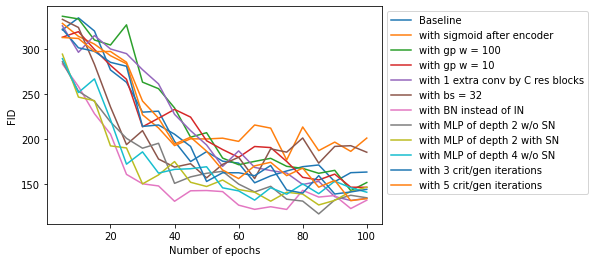

In [12]:
plot_fids_vs_epochs(fids_baseline_dict, label='Baseline')
plot_fids_vs_epochs(fids_sigmoid_after_enc_dict, label='with sigmoid after encoder')
plot_fids_vs_epochs(fids_gpw100_dict, label='with gp w = 100')
plot_fids_vs_epochs(fids_gpw10_dict, label='with gp w = 10')
plot_fids_vs_epochs(fids_deep_c_dict, label='with 1 extra conv by C res blocks')
plot_fids_vs_epochs(fids_bs32_dict, label='with bs = 32')
plot_fids_vs_epochs(fids_bn_dict, label='with BN instead of IN')
plot_fids_vs_epochs(fids_mlp2_dict, label='with MLP of depth 2 w/o SN')
plot_fids_vs_epochs(fids_mlp2_sn_dict, label='with MLP of depth 2 with SN')
plot_fids_vs_epochs(fids_mlp4_dict, label='with MLP of depth 4 w/o SN')
plot_fids_vs_epochs(fids_3c_iters_dict, label='with 3 crit/gen iterations')
ax = plot_fids_vs_epochs(fids_5c_iters_dict, label='with 5 crit/gen iterations')
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), ncol=1)

The baseline improved with all the working tweaks corresponds to **TR 1a**.

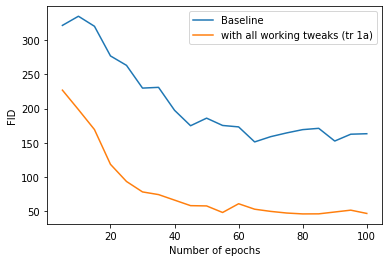

In [13]:
plot_fids_vs_epochs(fids_baseline_dict, label='Baseline')
_ = plot_fids_vs_epochs(fids_tr1_combotweaks_dict, label='with all working tweaks (tr 1a)')

Some more tweaks were tested by adding them to tr 1a:

* Skip connections provide a significant improvement. 
* Dropping pooling layers from encoder seems more or less neutral but it could help to preserve global features.

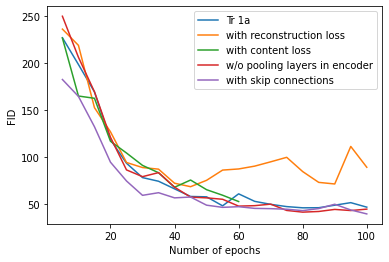

In [20]:
plot_fids_vs_epochs(fids_tr1_combotweaks_dict, label='Tr 1a')
plot_fids_vs_epochs(fids_tr1_combotweaks_recloss_dict, 
                    label='with reconstruction loss')
plot_fids_vs_epochs(fids_tr1_combotweaks_contloss_dict, 
                    label='with content loss')
plot_fids_vs_epochs(fids_tr1_combotweaks_noencpool_dict, 
                    label='w/o pooling layers in encoder')
ax = plot_fids_vs_epochs(fids_tr1_combotweaks_skips_dict, 
                         label='with skip connections')

#plot_fids_vs_epochs(fids_tr1_combotweaks_ema_dict, label='Tr 1a, EMA')
# plot_fids_vs_epochs(fids_tr1_combotweaks_recloss_ema_dict, 
#                     label='with reconstruction loss, EMA')
# plot_fids_vs_epochs(fids_tr1_combotweaks_contloss_ema_dict, 
#                     label='with content loss, EMA')
# plot_fids_vs_epochs(fids_tr1_combotweaks_noencpool_ema_dict, 
#                     label='w/o pooling layers in encoder')
# ax = plot_fids_vs_epochs(fids_tr1_combotweaks_skips_ema_dict, 
#                          label='with skip connections')
# ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), ncol=1)

A patch critic shows huge benefits too:

<AxesSubplot:xlabel='Number of epochs', ylabel='FID'>

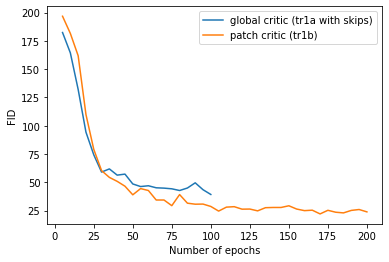

In [11]:
plot_fids_vs_epochs(fids_tr1_combotweaks_skips_dict, 
                    label='global critic (tr1a with skips)')
_ = plot_fids_vs_epochs(fids_tr1b_dict, 
                        label='patch critic (tr1b)')

Instance norm was also tested with little success. The reason may be the excessive difference between the datasets and the lack of diversity of the anime dataset. The results of these and other tweaks tested over model 1b are shown below:

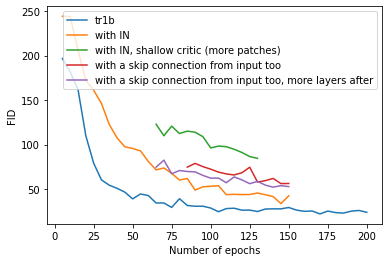

In [40]:
plot_fids_vs_epochs(fids_tr1b_dict, label='tr1b')
plot_fids_vs_epochs(fids_tr1b_inn_mlpsnnobn_dict, label='with IN')
plot_fids_vs_epochs(fids_tr1b_inn_patchCOut16_dict, 
                    label='with IN, shallow critic (more patches)')
plot_fids_vs_epochs(fids_tr1b_allskips_dict, 
                    label='with a skip connection from input too')
_ = plot_fids_vs_epochs(fids_tr1b_allskips_b_dict, 
                        label='with a skip connection from input too, more layers after')

To alleviate the lack of diversity issue and help the optimizer find a better correspondence, some dataset transforms were performed. ADA was also used (tr 2x) to increase the potential of training given the small size of the target dataset.

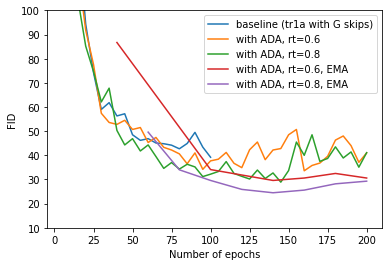

In [38]:
plot_fids_vs_epochs(fids_tr1_combotweaks_skips_dict, 
                    label='baseline (tr1a with G skips)')
plot_fids_vs_epochs(fids_tr2_dict, label='with ADA, rt=0.6')
plot_fids_vs_epochs(fids_tr2_rt08_dict, label='with ADA, rt=0.8')
plot_fids_vs_epochs(fids_tr2_ema_dict, label='with ADA, rt=0.6, EMA')
ax = plot_fids_vs_epochs(fids_tr2_rt08_ema_dict, label='with ADA, rt=0.8, EMA')
ax.set_ybound(10, 100)

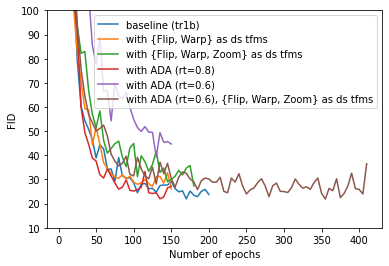

In [28]:
plot_fids_vs_epochs(fids_tr1b_dict, label='baseline (tr1b)')
plot_fids_vs_epochs(fids_tr1c_dict, label='with {Flip, Warp} as ds tfms')
plot_fids_vs_epochs(fids_tr1d_dict, label='with {Flip, Warp, Zoom} as ds tfms')
#plot_fids_vs_epochs(fids_tr2_dict, label='with ADA, rt=0.6')
#plot_fids_vs_epochs(fids_tr2_rt08_dict, label='with ADA, rt=0.8')
plot_fids_vs_epochs(fids_tr2b_dict, label='with ADA (rt=0.8)')
plot_fids_vs_epochs(fids_tr2c_dict, label='with ADA (rt=0.6)')
ax = plot_fids_vs_epochs(fids_tr2c_rt08_dict, 
                         label='with ADA (rt=0.6), {Flip, Warp, Zoom} as ds tfms')
ax.set_ybound(10, 100)

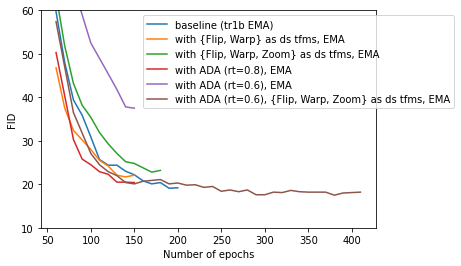

In [39]:
plot_fids_vs_epochs(fids_tr1b_ema_dict, label='baseline (tr1b EMA)')
plot_fids_vs_epochs(fids_tr1c_ema_dict, label='with {Flip, Warp} as ds tfms, EMA')
plot_fids_vs_epochs(fids_tr1d_ema_dict, label='with {Flip, Warp, Zoom} as ds tfms, EMA')
plot_fids_vs_epochs(fids_tr2b_ema_dict, label='with ADA (rt=0.8), EMA')
plot_fids_vs_epochs(fids_tr2c_ema_dict, label='with ADA (rt=0.6), EMA')
ax = plot_fids_vs_epochs(fids_tr2c_rt08_ema_dict, 
                         label='with ADA (rt=0.6), {Flip, Warp, Zoom} as ds tfms, EMA')
ax.set_ybound(10, 60)
_ = ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.))

Although it didn't make FIDs improve, using dataset transforms increased the similarity between inputs and outputs. For instance, 1c and 1d look much better than 1b in this regard.

# Performing evaluation

In [ ]:
base_fid_samples_path = Path('/kaggle/working/fid_samples')
n_fid_imgs = 10000

def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'real').mkdir()
        
def save_real_imgs(dls, n_imgs=10000, use_input_ds=False):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            tuple_idx = 0 if use_input_ds else 1
            img_t = dec_b[i][tuple_idx]
            img = PILImage.create(img_t)
            img_idx = n_imgs_left-1
            img.save(base_fid_samples_path/f'real/{img_idx}.jpg')
            #if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1            
            
def save_fake_imgs(learner, n_imgs=10000, **predict_n_kwargs):
    base_path = base_fid_samples_path
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    for i, (inp, img) in enumerate(preds_batch):
        PILImage.create(img).save(base_path/f'fake/{i}.jpg')

In [ ]:
!rm -R $base_fid_samples_path

In [ ]:
download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [ ]:
def exec_fid_proc():
    #!python -m pytorch_fid {base_fid_samples_path/'fake'} {base_fid_samples_path/'real'}
    proc_args = ["python", "-m", "pytorch_fid", base_fid_samples_path/'fake', 
                 base_fid_samples_path/'real']
    return subprocess.run(proc_args, stdout=subprocess.PIPE)

def fid_out_to_arr(fid_proc_out):
    if isinstance(fid_proc_out, bytes):
        fid_proc_out = fid_proc_out.decode(sys.stdout.encoding)
    float_fids = [round(float(line[5:].strip()), ndigits=1) 
                  for line in fid_proc_out.split('\n') 
                  if line.startswith('FID')]
    return float_fids

def eval_models(builders, n_epochs, base_path='./models', 
                fn_suffix='', ema=False):
    assert is_iterable(builders) or is_iterable(n_epochs)
    if not is_iterable(builders): 
        builders = [builders] * len(list(n_epochs))
    if not is_iterable(n_epochs): 
        n_epochs = [n_epochs] * len(list(builders))
    result = []
    for builder, n_ep in zip(builders, n_epochs):
        model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'refined_arch_face2anime_tr{model_id}{fn_suffix}_{n_ep}ep', 
                          with_opt=False, base_path=base_path, with_ema=ema)
        if ema: 
            learner = Learner(learner.dls, learner.ema_model,
                              loss_func=lambda *args: torch.tensor(0.))
        save_fake_imgs(learner, n_imgs=n_fid_imgs)
        completed_proc = exec_fid_proc()        
        print(f'---- {model_id}, after {n_ep} epochs ----')        
        print(completed_proc.stdout)        
        fid_value = fid_out_to_arr(completed_proc.stdout)
        result.extend(fid_value)
    return result

In [ ]:
save_real_imgs(dls, n_fid_imgs)

In [ ]:
eval_models(create_learner_1, range(5, 101, 5), base_path='./models')

In [ ]:
eval_models(create_learner_1, range(5, 101, 5), base_path='./models', ema=True)

In [ ]:
PILImage.create(base_fid_samples_path/'fake/9999.jpg')

## Reference FID

With 10000 images:

* FID input ds vs itself (CelebA vs CelebA) ~ 2.8
* FID target ds vs itself (Animecharacterfaces vs Animecharacterfaces) ~ 4.0